<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/09/0913.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install umap-learn[plot] kmodes
!wget -O 0913_class.csv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/0913_class.csv?raw=1
!wget -O 0913_zoo.csv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/0913_zoo.csv?raw=1
!wget -O funcs.py https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/09/0913_funcs.py?raw=1

## Agglomerative clustering with categorical data


In [2]:
# Zoo dataset : https://www.kaggle.com/datasets/uciml/zoo-animal-classification/code?datasetId=586&searchQuery=hier&select=zoo.csv

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from funcs import plot_cluster_dendrogram, cophenetic_corr, plot_silouethes_agglomer

from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA

from kmodes.kmodes import KModes

import umap
import umap.plot as uplot

sns.set_theme()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn

## Animal zoo dataset

The Zoo Dataset is a comprehensive collection of data about various animals found in zoos worldwide. The dataset is composed of several attributes related to these animals, such as:

- `animal_name`: The name of the animal.

- `hair`: Indicates if the animal has hair (1 for yes, 0 for no).
- `feathers`: Indicates if the animal has feathers (1 for yes, 0 for no).
- `eggs`: Indicates if the animal lays eggs (1 for yes, 0 for no).
- `milk`: Indicates if the animal produces milk (1 for yes, 0 for no).
- `airborne`: Indicates if the animal can fly (1 for yes, 0 for no).
- `aquatic`: Indicates if the animal lives in water (1 for yes, 0 for no).
- `predator`: Indicates if the animal is a predator (1 for yes, 0 for no).
- `toothed`: Indicates if the animal has teeth (1 for yes, 0 for no).
- `backbone`: Indicates if the animal has a backbone (1 for yes, 0 for no).
- `breathes`: Indicates if the animal breathes air (1 for yes, 0 for no).
- `venomous`: Indicates if the animal is venomous (1 for yes, 0 for no).
- `fins`: Indicates if the animal has fins (1 for yes, 0 for no).
- `legs`: Number of legs the animal has (integer value).
- `tail`: Indicates if the animal has a tail (1 for yes, 0 for no).
- `domestic`: Indicates if the animal is domesticated (1 for yes, 0 for no).
- `catsize`: Indicates if the animal is cat-sized or larger (1 for yes, 0 for no).
- `class_type`: Numerical code indicating the animal's taxonomic class.


Citation : Forsyth,Richard. (1990). Zoo. UCI Machine Learning Repository. https://doi.org/10.24432/C5R59V.

In [3]:
# in this demo, our goal will be to cluster the animals based on their characteristics
# and to see if we will manage to split animals into classes by using their characteristics

# Load the data
zoo_path = '0913_zoo.csv'
zoo_df = pd.read_csv(zoo_path)

# Load class mapping
class_mappings = '0913_class.csv'
class_mapper = pd.read_csv(class_mappings)

In [4]:
zoo_df.head()
# all the categorical features are already ordinaly encoded

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [5]:
class_mapper
# metadata
# Class_Number: class id
# Class_Type: class name

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


In [6]:
zoo_df.shape

(101, 18)

In [7]:
zoo_df.isna().sum(axis=0)
# we do not have a missing values

,0
animal_name,0
hair,0
feathers,0
eggs,0
milk,0
airborne,0
aquatic,0
predator,0
toothed,0
backbone,0


In [8]:
# Check number of unique animals
zoo_df['animal_name'].nunique()
# some names are duplicated

100

In [9]:
# Drop duplicates since there should be one species per row
zoo_df = zoo_df.drop_duplicates('animal_name')
zoo_df.shape

(100, 18)

In [10]:
# Map class id to class name
class_map_dict = class_mapper.set_index('Class_Number')['Class_Type'].to_dict()
zoo_df['class_type'] = zoo_df['class_type'].map(class_map_dict)

# Extract class as separate object and drop class from zoo_df
animal_class = zoo_df['class_type']
zoo_df = zoo_df.drop(columns=['class_type'])

<ipython-input-10-efb8e394dba8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zoo_df['class_type'] = zoo_df['class_type'].map(class_map_dict)


In [11]:
# Set animal name as index
zoo_df = zoo_df.set_index('animal_name', drop=True)

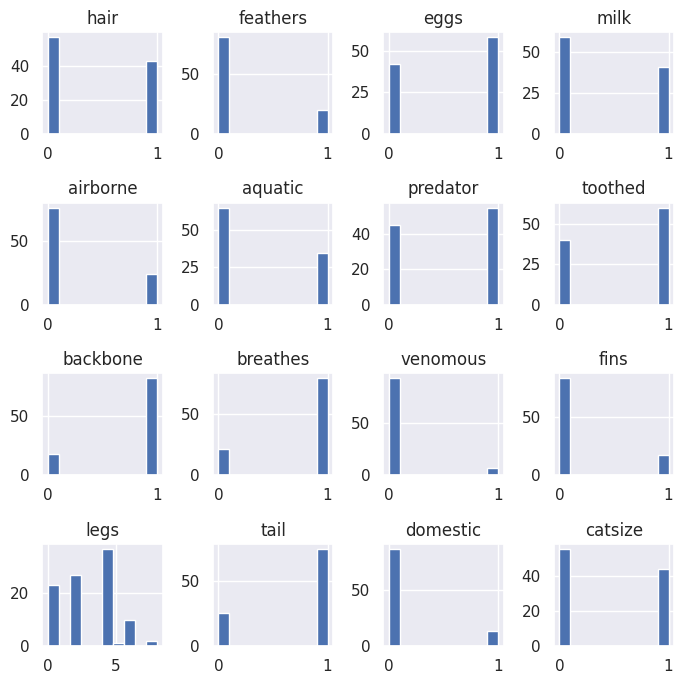

In [12]:
_ = zoo_df.hist(figsize=(7,7))
plt.tight_layout()
# we can see the distribution of values in our categorical features
# majority of features is binary (except "legs")

### Agglomerative clustering with hamming distance

In [13]:
linkage_matrix = linkage(
    zoo_df.to_numpy(),
    method='average',
    metric='hamming'
)

In [14]:
cophenetic_corr(
    linkage_matrix=linkage_matrix,
    data_mtx = zoo_df.to_numpy(),
    distance_measure='hamming'
)
# the dendrogram is a good representative of our data

Cophenetic correlation : 0.8584617992386253


In [15]:
linkage_matrix[:,2] += 0.001
# trick, in this data set, Hamming distance will turn out to be 0,
# which can be problematic when displaying the data on the dendrogram,
# so we will add small constants to all the distances

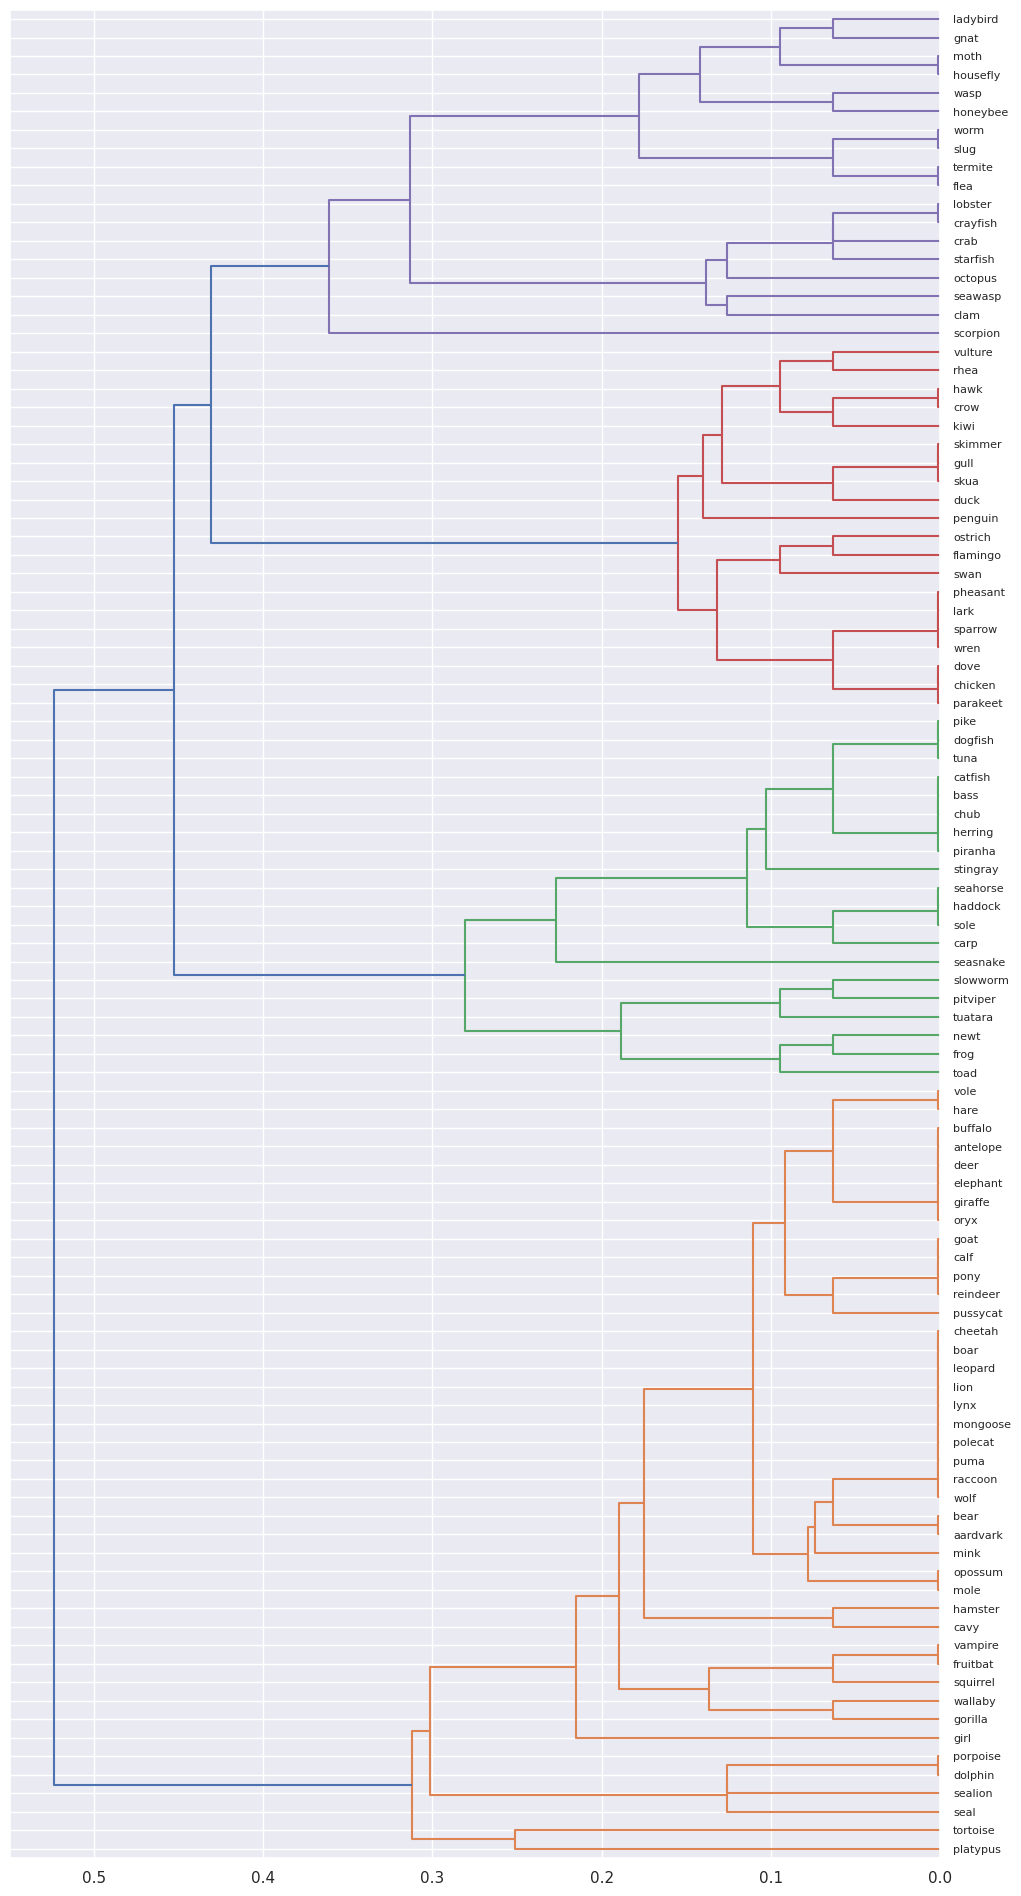

In [16]:
plt.rcParams['figure.figsize'] = [12, 24]
_ = dendrogram(
    linkage_matrix,
    labels=zoo_df.index,
    orientation='left',
    leaf_font_size=8
)
# we have all kinds of groups and subgroups describing relationships between our animals

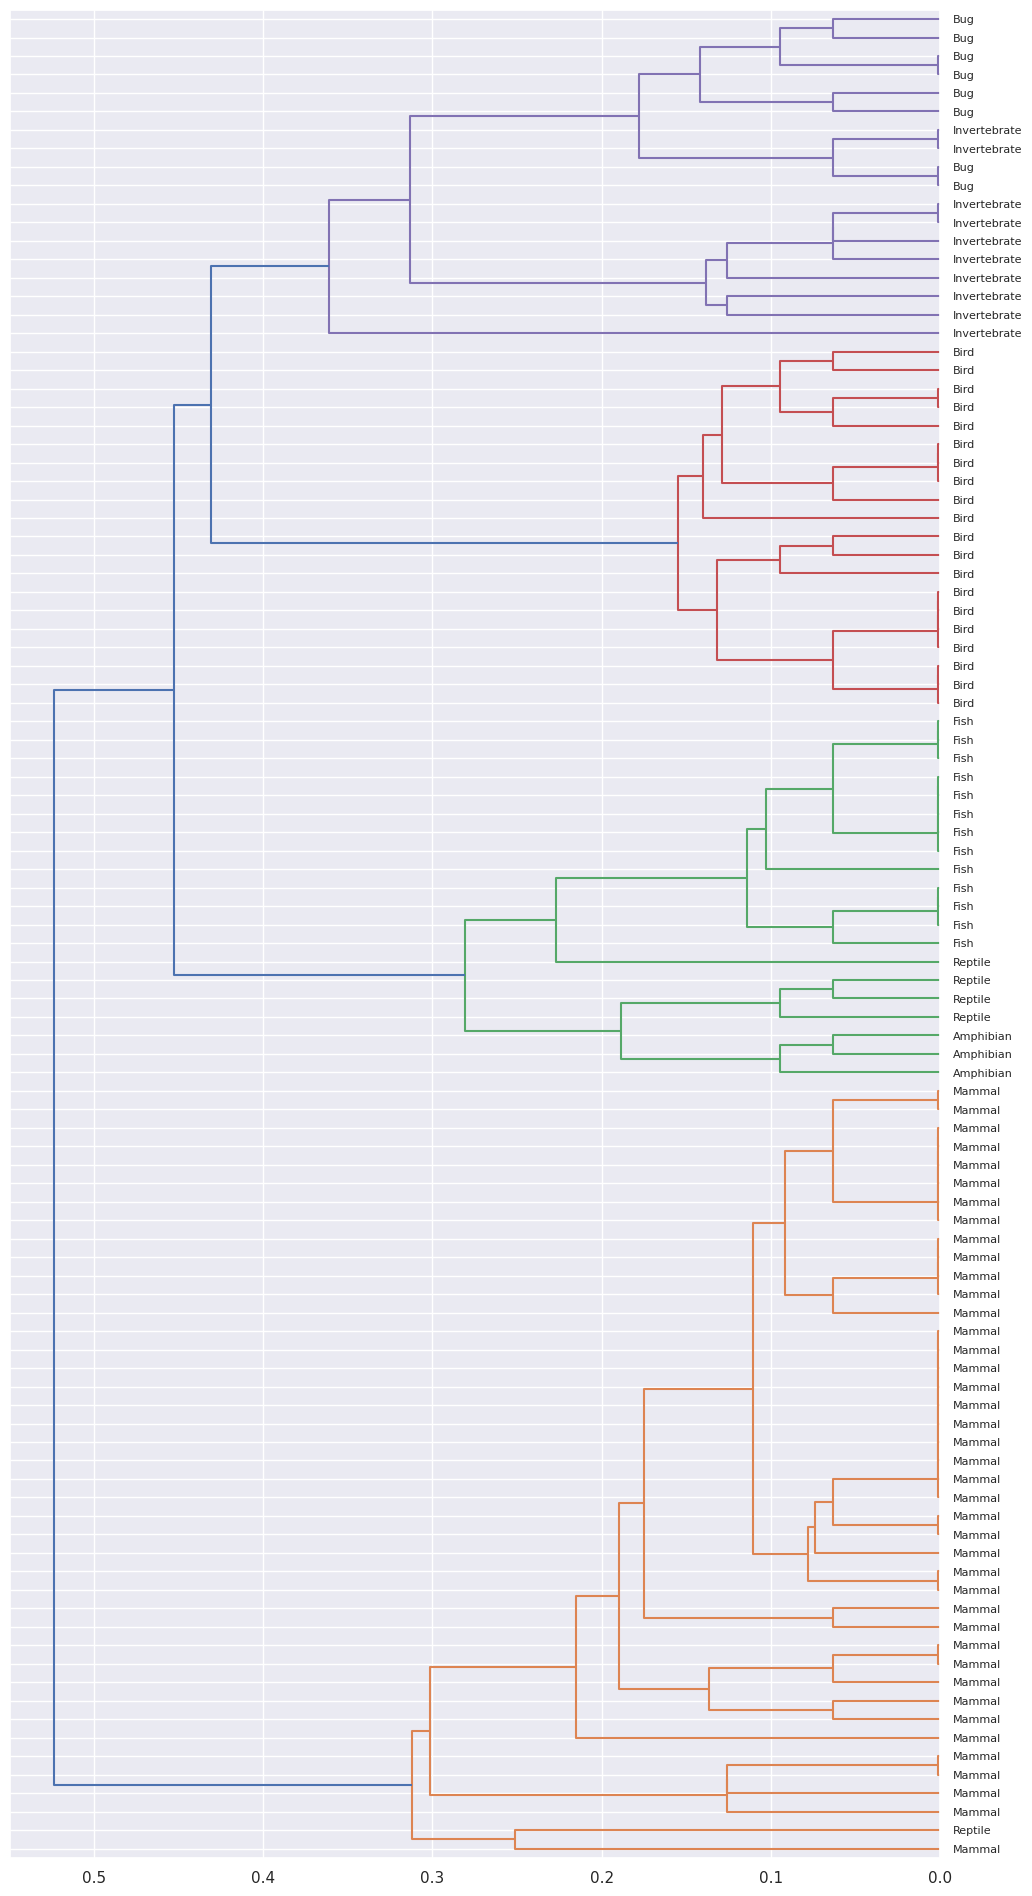

In [17]:
plt.rcParams['figure.figsize'] = [12, 24]
_ = dendrogram(
    linkage_matrix,
    labels=animal_class.to_numpy(),
    orientation='left',
    leaf_font_size=8
)
# this dendrogram successfully manages to separate different animal classes
# and also gives us relationship between different classes

In [18]:
# Perform clustering
clusters = fcluster(Z=linkage_matrix, t=0.28, criterion='distance')
clusters

array([3, 3, 5, 3, 3, 3, 3, 5, 5, 3, 3, 6, 5, 7, 7, 7, 6, 3, 5, 2, 6, 6,
       3, 6, 8, 4, 3, 3, 3, 8, 3, 3, 6, 5, 3, 3, 6, 5, 8, 8, 6, 8, 6, 3,
       3, 7, 3, 3, 3, 3, 8, 4, 7, 3, 3, 6, 6, 6, 6, 5, 5, 4, 1, 3, 3, 2,
       3, 3, 3, 3, 6, 9, 5, 2, 2, 5, 7, 6, 6, 4, 8, 5, 6, 3, 7, 5, 6, 8,
       4, 1, 4, 5, 3, 3, 6, 3, 8, 3, 8, 6], dtype=int32)

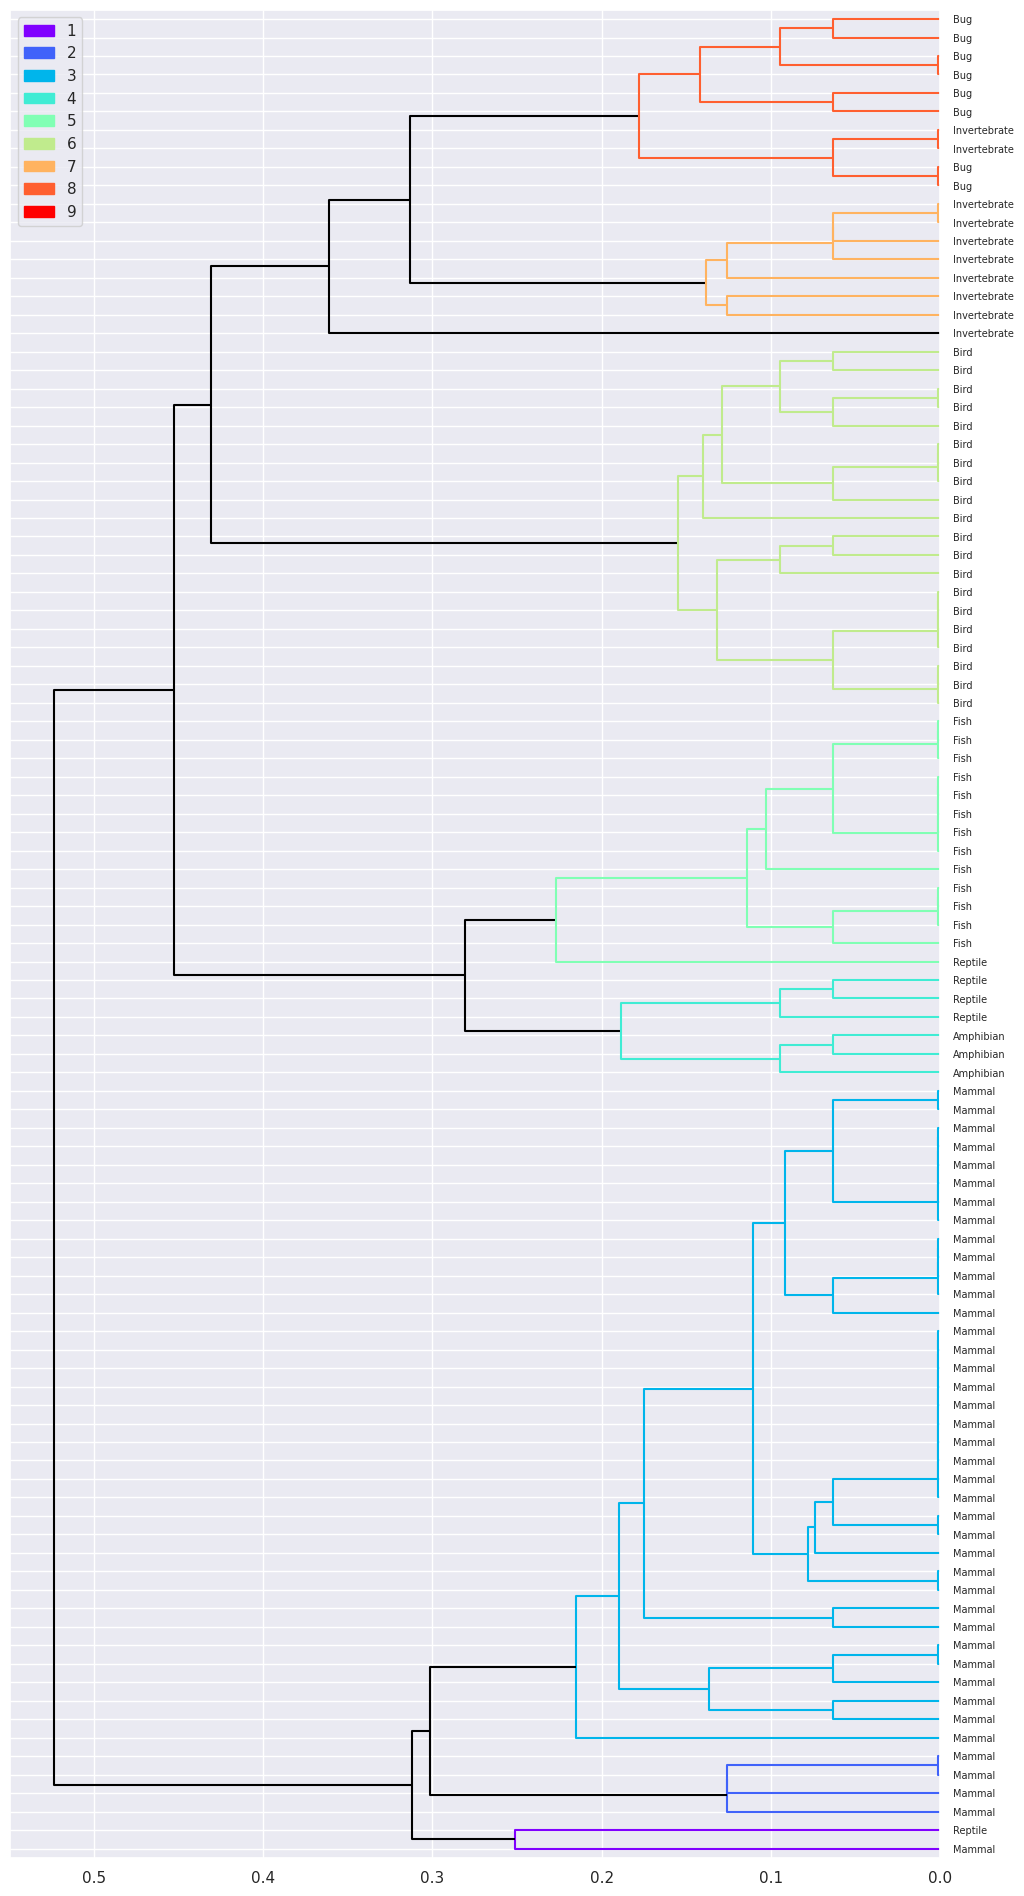

In [19]:
_ = plot_cluster_dendrogram(
    linkage_matrix=linkage_matrix,
    dataset_df=zoo_df,
    clusters=clusters,
    leaf_font_size=7,
    labels=animal_class.to_numpy()
)
# we have clusters containing different animal types
# we have clusters that are a bit weird
# so here we have a reptile and a mammal together
# and we have a group of mammals that is different compared to the others

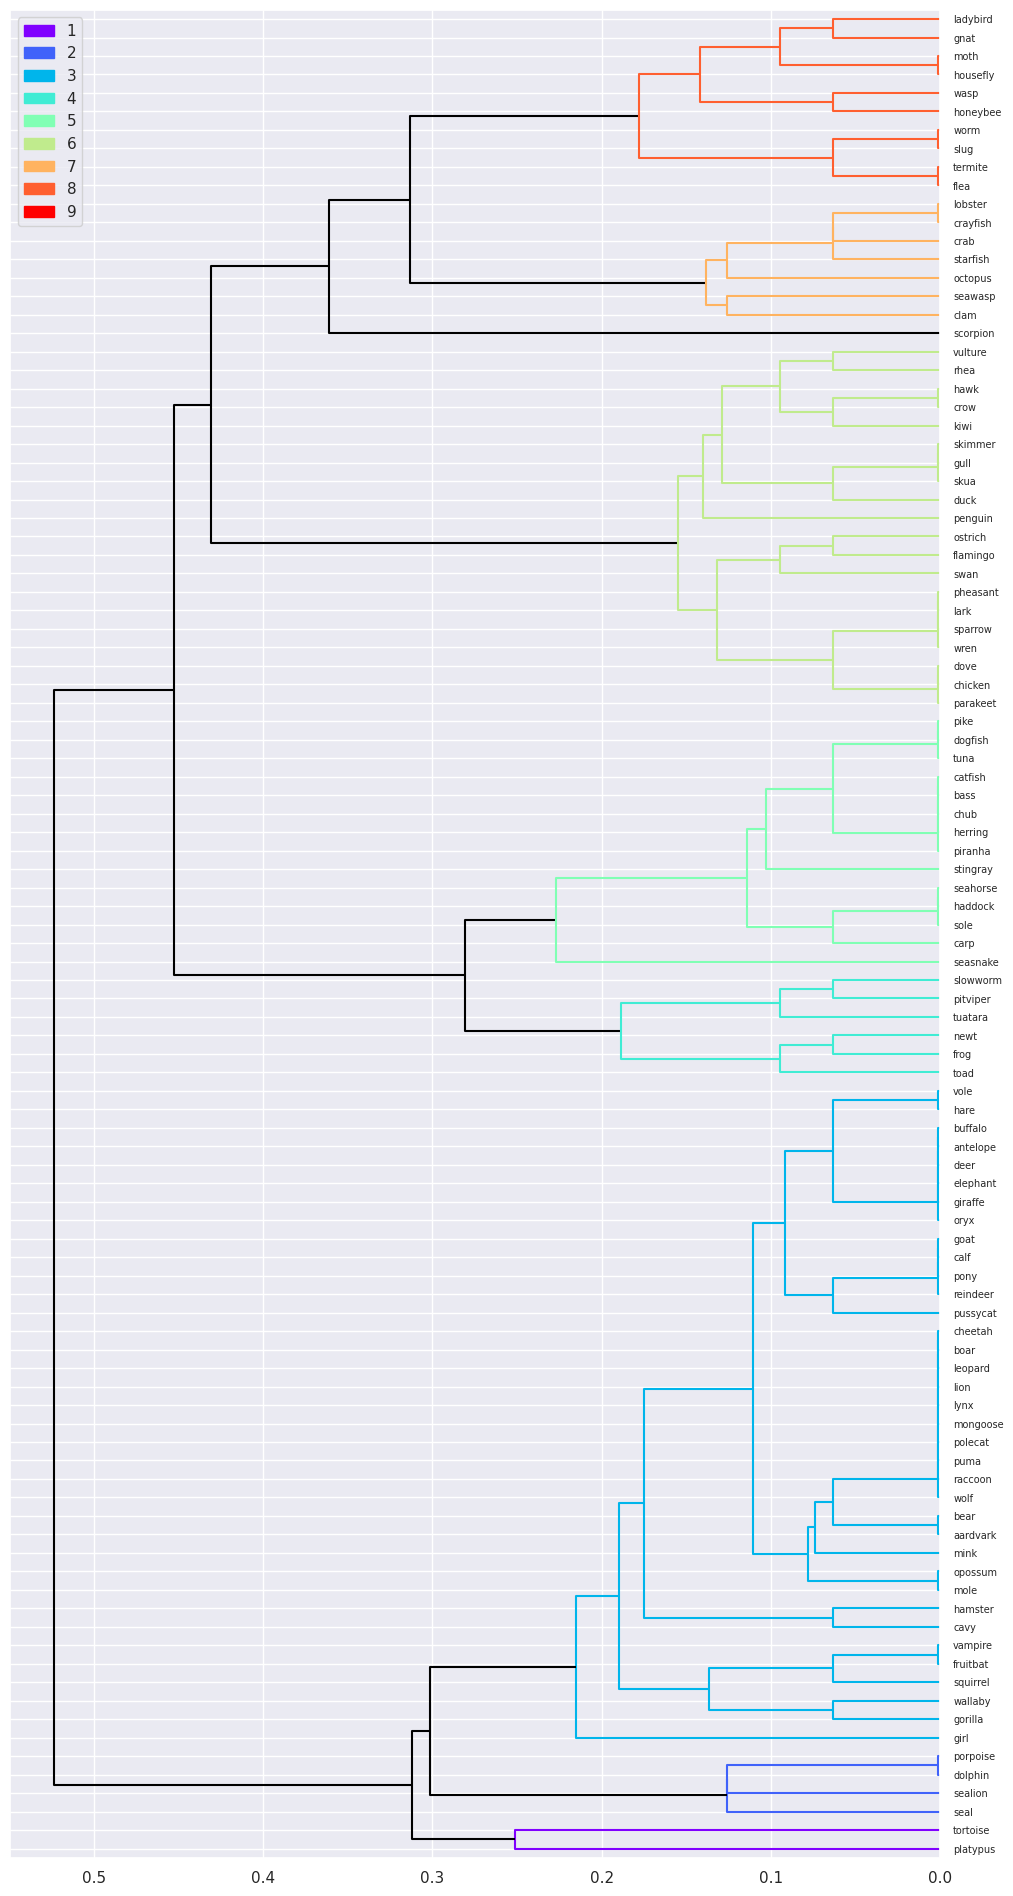

In [20]:
dendr_colors = plot_cluster_dendrogram(
    linkage_matrix=linkage_matrix,
    dataset_df=zoo_df,
    clusters=clusters,
    leaf_font_size=7
)
# let's explore this
# we have a mammals that live in water
# and also we have this group containing a turtle and a platypus which have similar characteristics despite belonging to different animal classes

In [21]:
pca = PCA()
pca_data = pca.fit_transform(zoo_df.values)
np.round(pca.explained_variance_ratio_, 2)

array([0.63, 0.15, 0.07, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.  , 0.  , 0.  , 0.  ])

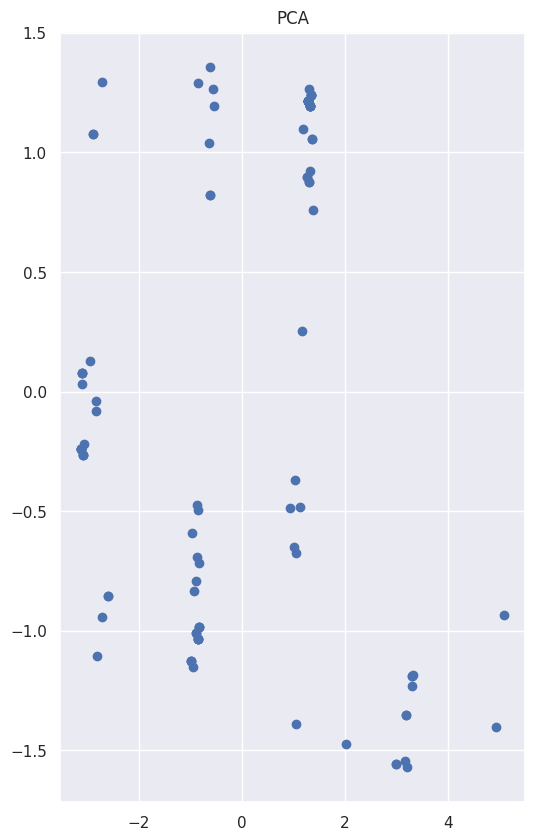

In [22]:
plt.figure(figsize=(6,10))
plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.title('PCA')
plt.show()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.10/dist-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

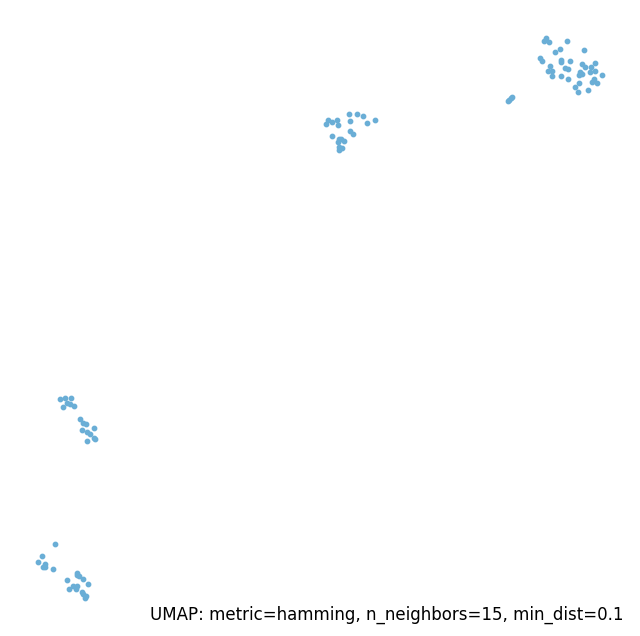

In [23]:
umap_obj = umap.UMAP(n_neighbors=15, metric='hamming')
embedding_mtx = umap_obj.fit_transform(zoo_df)

uplot.points(umap_obj)

/usr/local/lib/python3.10/dist-packages/datashader/transfer_functions/__init__.py:332: RuntimeWarning: invalid value encountered in divide
  scaled_data = (data - span[0])/(span[1] - span[0])


<Axes: >

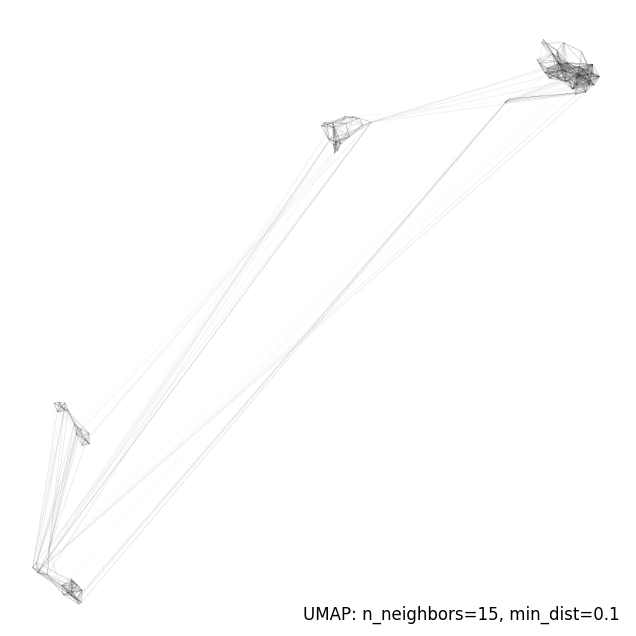

In [24]:
umap.plot.connectivity(umap_obj, show_points=True)

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

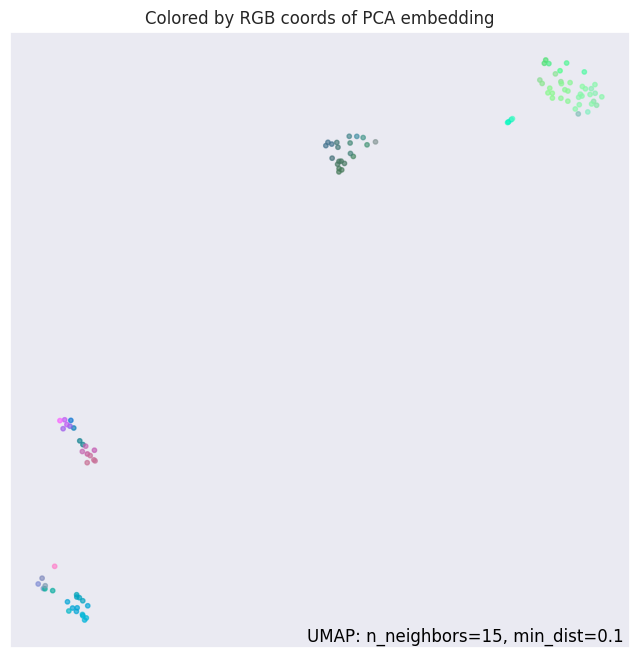

In [25]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
umap.plot.diagnostic(umap_obj, diagnostic_type='pca',ax=ax)

Text(0.5, 1.0, 'k-means on UMAP embedding')

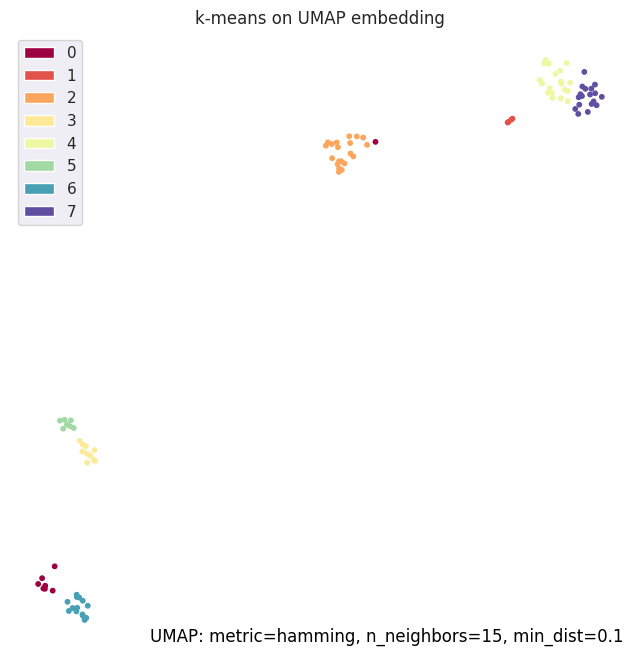

In [26]:
kmode = KModes(n_clusters=8)
kmode.fit_predict(zoo_df)
uplot.points(umap_obj, labels=kmode.labels_)
plt.title('k-means on UMAP embedding')

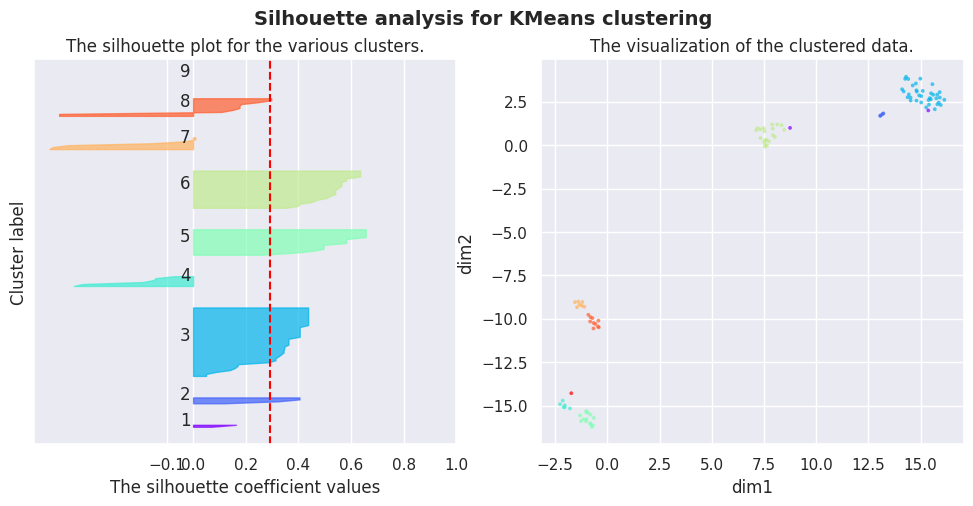

In [27]:
_ = plot_silouethes_agglomer(
    data_df=zoo_df,
    clusters=clusters,
    dendr_colors=dendr_colors,
    embedding_mtx=embedding_mtx
)

In [28]:
ari = adjusted_rand_score(kmode.labels_, clusters)
print(f"ARI: {ari:.2f}")

score1 = silhouette_score(zoo_df, kmode.labels_, metric='hamming')
score2 = silhouette_score(zoo_df, clusters, metric='hamming')
print(f"silhouette score: {score1:.2f} vs. {score2:.2f}")

def sse_hamming(df, labels):
    df = df.copy()
    df["label"] = labels

    sse = 0
    for i in set(labels):
        df_sub = df[df.label == i]
        center = df_sub.iloc[:, :-1].mode().values[0]
        distance_from_center = np.sum(df_sub.iloc[:, :-1].values != center, axis=1)
        sse += np.sum(distance_from_center)
    return sse

sse1 = sse_hamming(zoo_df, kmode.labels_)
sse2 = sse_hamming(zoo_df, clusters)
print(f"inertia: ({kmode.cost_:.2f}),{sse1:.2f} vs. {sse2:.2f}")

ARI: 0.75
silhouette score: 0.52 vs. 0.56
inertia: (118.00),118.00 vs. 128.00


Text(0.5, 1.0, 'k-means on UMAP embedding')

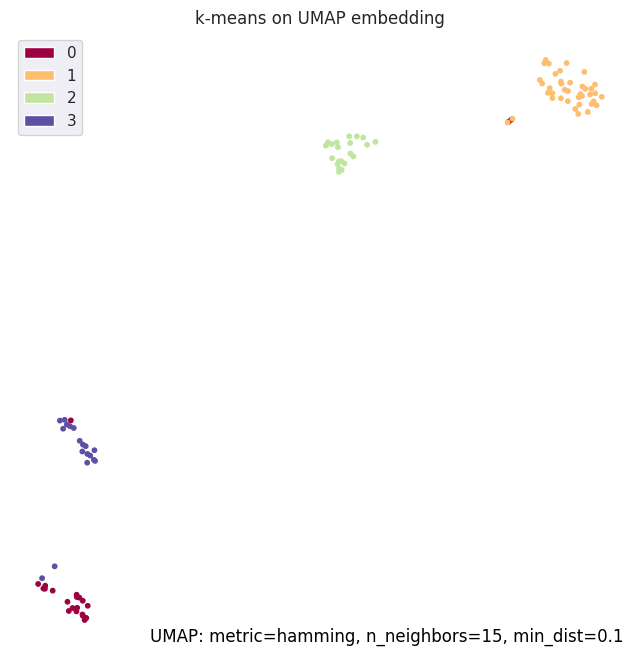

In [30]:
kmode = KModes(n_clusters=4)
kmode.fit_predict(zoo_df)
uplot.points(umap_obj, labels=kmode.labels_)
plt.title('k-means on UMAP embedding')

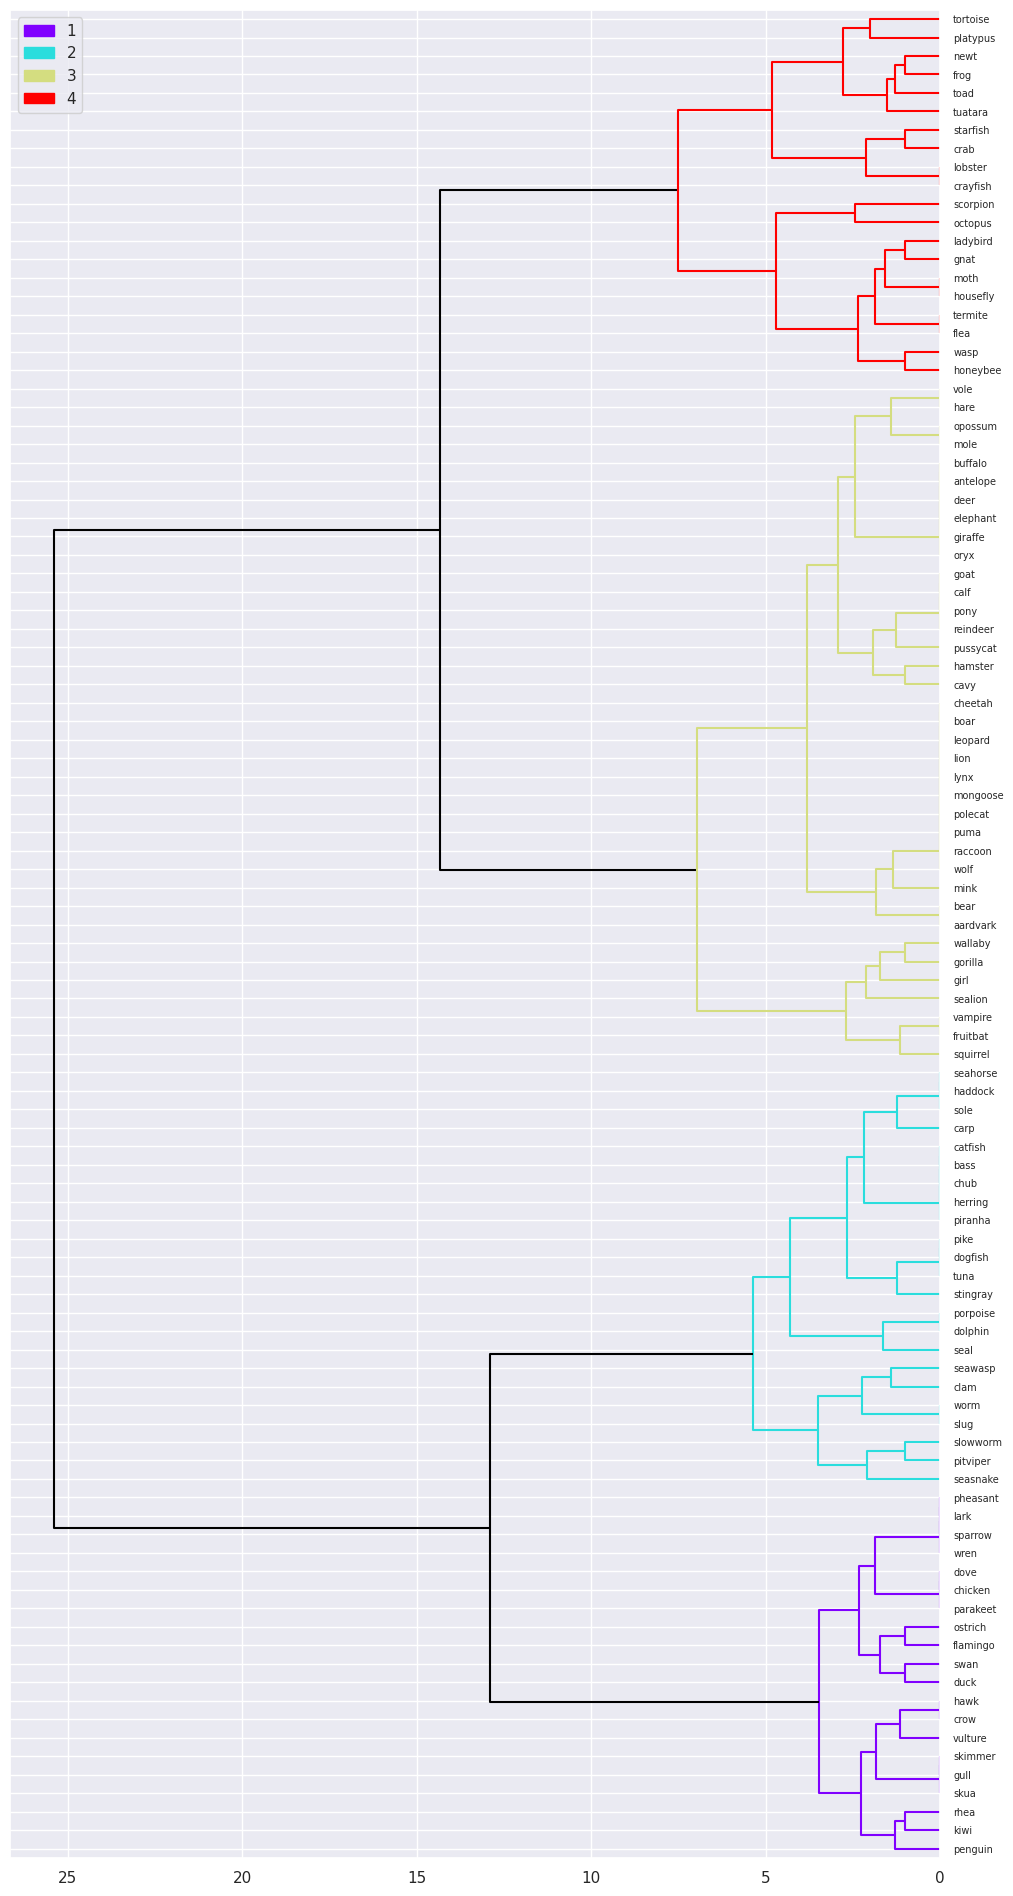

In [31]:
linkage_matrix = linkage(zoo_df.to_numpy(), method='ward')

clusters = fcluster(
    Z=linkage_matrix,
    t=4,
    criterion='maxclust',
)

dendr_colors = plot_cluster_dendrogram(
    linkage_matrix=linkage_matrix,
    dataset_df=zoo_df,
    clusters=clusters,
    leaf_font_size=7
)

In [32]:
ari = adjusted_rand_score(kmode.labels_, clusters)
print(f"ARI: {ari:.2f}")

score1 = silhouette_score(zoo_df, kmode.labels_, metric='hamming')
score2 = silhouette_score(zoo_df, clusters, metric='hamming')
print(f"silhouette score: {score1:.2f} vs. {score2:.2f}")

sse1 = sse_hamming(zoo_df, kmode.labels_)
sse2 = sse_hamming(zoo_df, clusters)
print(f"inertia: ({kmode.cost_:.2f}),{sse1:.2f} vs. {sse2:.2f}")

ARI: 0.81
silhouette score: 0.57 vs. 0.51
inertia: (183.00),183.00 vs. 206.00
